# IMAGE SUPER RESOLUTION (SRGAN)

**This is implementation of SRGAN for self created Drone dataset**

In [1]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch

# check the allocation machine
isCuda = torch.cuda.is_available()
machine = torch.cuda.get_device_properties(0) if isCuda else 'cpu'
print("Assigned Machine: ", machine)
device = torch.device('cuda:0' if isCuda else 'cpu')
print(f"cuda avaiable: {isCuda}, Device: {device}")

Assigned Machine:  _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16130MB, multi_processor_count=80)
cuda avaiable: True, Device: cuda:0


In [3]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session8-SR/notebooks/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session8-SR/notebooks


In [4]:
# Import standard packages
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from math import log10

import pandas as pd
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.utils.data import DataLoader
from tqdm import tqdm

import pytorch_ssim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# To autoreload all te custom files when modified
import autoreload
%load_ext autoreload
%autoreload

In [6]:
import shutil
#shutil.rmtree('./logs/logs_tmp')

In [7]:
from pathlib import Path

# important folders used in this application

Path(f'logs').mkdir(exist_ok=True)

SOLUTION_LOG_DIR = f"logs/logs_drone_sf2"     # root directoy for all the log of this notebook
Path(f'./{SOLUTION_LOG_DIR}').mkdir(exist_ok=True)

SAVED_MODELS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_models') # location to save models
SAVED_MODELS_DIR.mkdir(exist_ok=True)

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_results')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

PLOT_DIR = Path(f'./{SOLUTION_LOG_DIR}/doc_images')
PLOT_DIR.mkdir(exist_ok=True)

In [8]:
# Application specific configurations
config_params = dict(
    seed=1,
    batch_size=64,
    num_workers=6,
    epochs=100,
    upscale_factor=2 
)

torch.manual_seed(config_params['seed'])
if isCuda:
   torch.cuda.manual_seed(config_params['seed'])

In [9]:
# dataset path where zip files are placed.
src_dataset_dir = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session2/s2_dataset'

#unzip locations: note path shall be colab internal memory location not on mounted drive.
root_dataset = '/content/eva4p2_s8_dataset'

In [10]:
import shutil
#shutil.rmtree(root_dataset)

In [11]:
#class_list = ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
classname = 'Large QuadCopters' #'Small QuadCopters' ## 
class_list = [classname]

## Preparing Dataset

In [12]:
import utils.data_utils as dutils
import shutil

if Path(root_dataset).exists():
  shutil.rmtree(root_dataset)

In [13]:
# Extracting zipped dataset into colab internal memory
%%time

import zipfile
def extract_dataset(fn, dest):
    with open(fn, 'rb') as f:
      zf = zipfile.ZipFile(f)
      zf.extractall(dest)
      
# create root destination folder
if not Path(root_dataset).exists():
  Path(root_dataset).mkdir(exist_ok=True)

# extract individual class zip file
for classname in class_list:
  class_zipname = f'{src_dataset_dir}/{classname}.zip'  
  class_dir = f'{root_dataset}/{classname}' # class folder unzip location
  if not Path(class_dir).exists():
    print(f'Extracting {classname} images...')
    extract_dataset(fn=class_zipname, dest=class_dir)

Extracting Large QuadCopters images...
CPU times: user 3.46 s, sys: 995 ms, total: 4.46 s
Wall time: 5.01 s


# Prepare Data Transforms and DataLoader

In [14]:
from PIL import Image
import os, sys
import datetime

dst_datadir = '/content/eva4p2_s7_dataset_working'

if Path(dst_datadir).exists():
  shutil.rmtree(dst_datadir)

In [15]:
# Split train:test data
dutils.prepare_dataset(root_dataset, dst_datadir, ds_limit=1000, valid_size=0.03)

Preparing train/val dataset..
Dataset is created..


In [16]:
from utils.data_utils_srgan import TrainDatasetFromFolder, ValDatasetFromFolder, display_transform

CROP_SIZE = 88
UPSCALE_FACTOR = 2

train_set = TrainDatasetFromFolder(f'{dst_datadir}/train/{classname}', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_set = ValDatasetFromFolder(f'{dst_datadir}/val/{classname}', upscale_factor=UPSCALE_FACTOR)
train_loader = DataLoader(dataset=train_set, num_workers=config_params["num_workers"], batch_size=config_params["batch_size"], shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=config_params["num_workers"], batch_size=1, shuffle=False)

In [17]:
print(f'Train size: {len(train_loader.dataset)}')
print(f'Test size: {len(val_loader.dataset)}')

Train size: 970
Test size: 30


In [18]:
# dataloader and image dimension
lr_images, hr_images = next(iter(train_loader))
print(f'LR image size: {lr_images.shape}')
print(f'HR image size: {hr_images.shape}')

LR image size: torch.Size([64, 3, 44, 44])
HR image size: torch.Size([64, 3, 88, 88])


# Visualize few training images

In [19]:
def plot_dataset_images(data_loader, device, figsize=(10,9), num_of_images=20, save_filename=None):
    cnt = 0
    fig = plt.figure(figsize=figsize)
    for lr, hr in data_loader:
      data = hr.to(device)
      for index, img in enumerate(data):
        ax = fig.add_subplot(4, 5, cnt+1, xticks=[], yticks=[])
        ax.axis('on')
        npimg = img.cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

        cnt += 1
        if(cnt==num_of_images):
          break
      if(cnt==num_of_images):
        break
    if save_filename:
      fig.savefig(save_filename)
  
    return

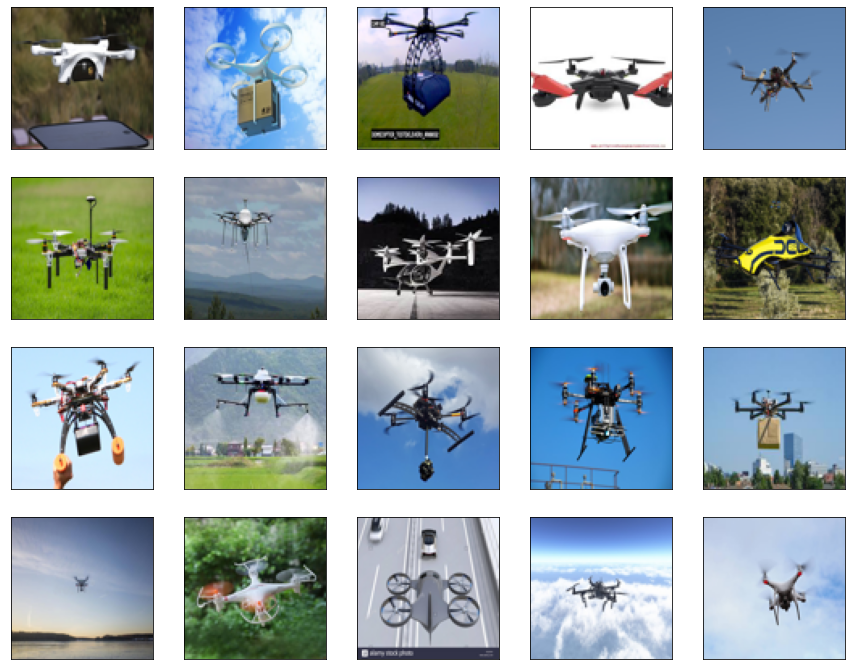

In [20]:
plot_dataset_images(train_loader, device, figsize=(15,12), save_filename=f'{PLOT_DIR}/dataset_samples.jpg')

# SRGAN Network Model

In [21]:
MODEL_NAME = "SRGAN"
MAX_EPOCH = config_params["epochs"]
BATCH_SIZE = config_params["batch_size"]
UPSCALE_FACTOR = config_params["upscale_factor"]

In [22]:
from models.srgan_net import Generator, Discriminator

netG = Generator(UPSCALE_FACTOR).to(device)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
netD = Discriminator().to(device)
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

# generator parameters: 586506
# discriminator parameters: 5215425


In [23]:
from utils.loss import GeneratorLoss
generator_criterion = GeneratorLoss().to(device)

In [24]:
import torch.optim as optim

#optimizer = optim.Adam(netG.parameters(), lr=0.001, weight_decay=1e-4)
optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

In [25]:
print(f'MAX_EPOCH: {MAX_EPOCH}\nBATCH_SIZE: {BATCH_SIZE}\nUPSCALE_FACTOR: {UPSCALE_FACTOR}')

MAX_EPOCH: 100
BATCH_SIZE: 64
UPSCALE_FACTOR: 2


In [26]:
from torch.autograd import Variable
import gc

results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

SAVE_MODEL_INTERVAL = 10

for epoch in range(1, MAX_EPOCH + 1):
        train_bar = tqdm(train_loader)
        running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}
    
        netG.train()
        netD.train()
        for data, target in train_bar:
            g_update_first = True
            batch_size = data.size(0)
            running_results['batch_sizes'] += batch_size
    
            ############################
            # (1) Update D network: maximize D(x)-1-D(G(z))
            ###########################
            real_img = Variable(target).to(device)
            z = Variable(data).to(device)
            fake_img = netG(z)
    
            netD.zero_grad()
            real_out = netD(real_img).mean()
            fake_out = netD(fake_img).mean()
            d_loss = 1 - real_out + fake_out
            d_loss.backward(retain_graph=True)
            optimizerD.step()
    
            ############################
            # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
            ###########################
            netG.zero_grad()

            # add these two line to avoid runtime error
            fake_img = netG(z)
            fake_out = netD(fake_img).mean()

            g_loss = generator_criterion(fake_out, fake_img, real_img)        
            g_loss.backward()
            
            #fake_img = netG(z)
            #fake_out = netD(fake_img).mean()
            
            optimizerG.step()

            # loss for current batch before optimization 
            running_results['g_loss'] += g_loss.item() * batch_size
            running_results['d_loss'] += d_loss.item() * batch_size
            running_results['d_score'] += real_out.item() * batch_size
            running_results['g_score'] += fake_out.item() * batch_size
    
            train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
                epoch, MAX_EPOCH, running_results['d_loss'] / running_results['batch_sizes'],
                running_results['g_loss'] / running_results['batch_sizes'],
                running_results['d_score'] / running_results['batch_sizes'],
                running_results['g_score'] / running_results['batch_sizes']))
    
        netG.eval()
        out_path = f'{SAVED_RESULTS_DIR}/training_results/SRF_' + str(UPSCALE_FACTOR) + '/'
        if not os.path.exists(out_path):
            os.makedirs(out_path)

        gc.collect()
        
        with torch.no_grad():
            val_bar = tqdm(val_loader)
            valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
            val_images = []
            for val_lr, val_hr_restore, val_hr in val_bar:
                batch_size = val_lr.size(0)
                valing_results['batch_sizes'] += batch_size
                lr = val_lr.to(device)
                hr = val_hr.to(device)

                sr = netG(lr)
        
                batch_mse = ((sr - hr) ** 2).data.mean()
                valing_results['mse'] += batch_mse * batch_size
                batch_ssim = pytorch_ssim.ssim(sr, hr).item()
                valing_results['ssims'] += batch_ssim * batch_size
                valing_results['psnr'] = 10 * log10((hr.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))
                valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
                val_bar.set_description(
                    desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (valing_results['psnr'], valing_results['ssim']))

                # only store few results
                if(len(val_images) < 30):
                  val_images.extend(
                      [display_transform()(val_hr_restore.squeeze(0)), display_transform()(hr.data.cpu().squeeze(0)),
                      display_transform()(sr.data.cpu().squeeze(0))])
                  
            val_images = torch.stack(val_images)
            val_images = torch.chunk(val_images, val_images.size(0) // 15)
            val_save_bar = tqdm(val_images, desc='[saving training results]')
            index = 1
            for image in val_save_bar:
                image = utils.make_grid(image, nrow=3, padding=5)
                utils.save_image(image, out_path + 'epoch_%d_index_%d.png' % (epoch, index), padding=5)
                index += 1
    
        gc.collect()

        # save model parameters
        if epoch % SAVE_MODEL_INTERVAL == 0:
          torch.save(netG, f'{SAVED_MODELS_DIR}/netG_epoch{epoch}_{UPSCALE_FACTOR}_cuda.pt')
          #torch.save(netD, f'{SAVED_MODELS_DIR}/netD_epoch{epoch}_{UPSCALE_FACTOR}_cuda.pt')

        # save loss\scores\psnr\ssim
        results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
        results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
        results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
        results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
        results['psnr'].append(valing_results['psnr'])
        results['ssim'].append(valing_results['ssim'])
    
        '''
        if epoch % 10 == 0 and epoch != 0:
            out_path = 'statistics/'
            data_frame = pd.DataFrame(
                data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                      'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim']},
                index=range(1, epoch + 1))
            data_frame.to_csv(out_path + 'srf_' + str(UPSCALE_FACTOR) + '_train_results.csv', index_label='Epoch')
        '''

[1/100] Loss_D: 0.9266 Loss_G: 0.0438 D(x): 0.4804 D(G(z)): 0.3959: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]
[converting LR images to SR images] PSNR: 16.5559 dB SSIM: 0.5981: 100%|██████████| 30/30 [00:02<00:00, 14.71it/s]
[saving training results]: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]
[2/100] Loss_D: 0.9442 Loss_G: 0.0198 D(x): 0.6766 D(G(z)): 0.6037: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]
[converting LR images to SR images] PSNR: 18.6140 dB SSIM: 0.7600: 100%|██████████| 30/30 [00:01<00:00, 15.45it/s]
[saving training results]: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]
[3/100] Loss_D: 1.0063 Loss_G: 0.0162 D(x): 0.6415 D(G(z)): 0.6421: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]
[converting LR images to SR images] PSNR: 20.7812 dB SSIM: 0.7635: 100%|██████████| 30/30 [00:01<00:00, 15.46it/s]
[saving training results]: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]
[4/100] Loss_D: 0.9972 Loss_G: 0.0149 D(x): 0.7230 D(G(z)): 0.7230: 100%|██████████| 16/

In [27]:
torch.save(netG, f'{SAVED_MODELS_DIR}/srgan_netG_cuda.pt')
torch.save(netD, f'{SAVED_MODELS_DIR}/srgan_netD_cuda.pt')

In [28]:
def plot_losses(titlename, results, save_filename=None):
    start_idx = 0
    fig, axs = plt.subplots(figsize=(14,8))

    x_size = len(results['d_loss'])-start_idx

    legend_list = ['discriminitive_loss', 'generative_loss']

    # plot losses
    axs.plot(range(0,x_size), results['d_loss'][start_idx:])
    axs.plot(range(0,x_size), results['g_loss'][start_idx:])

    axs.set_title(titlename)
    axs.set_ylabel('Losses')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,x_size+1),x_size/10)
    axs.legend(legend_list, loc='best')
    plt.show()

    if(save_filename != None):
      fig.savefig(save_filename)

def plot_scores(titlename, results, save_filename=None):
    start_idx = 0
    fig, axs = plt.subplots(figsize=(14,8))

    x_size = len(results['d_score'])-start_idx

    legend_list = ['discriminitive_score', 'generative_score']

    # plot losses
    axs.plot(range(0,x_size), results['d_score'][start_idx:])
    axs.plot(range(0,x_size), results['g_score'][start_idx:])

    axs.set_title(titlename)
    axs.set_ylabel('Scores')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,x_size+1),x_size/10)
    axs.legend(legend_list, loc='best')
    plt.show()

    if(save_filename != None):
      fig.savefig(save_filename)

def plot_psnr_ssim(titlename, results, save_filename=None):
    start_idx = 0
    fig, axs = plt.subplots(figsize=(14,8))

    x_size = len(results['psnr'])-start_idx

    legend_list = ['psnr', 'ssim']

    # plot losses
    axs.plot(range(0,x_size), results['psnr'][start_idx:])
    axs.plot(range(0,x_size), results['ssim'][start_idx:])

    axs.set_title(titlename)
    axs.set_ylabel('Values')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,x_size+1),x_size/10)
    axs.legend(legend_list, loc='best')
    plt.show()

    if(save_filename != None):
      fig.savefig(save_filename)

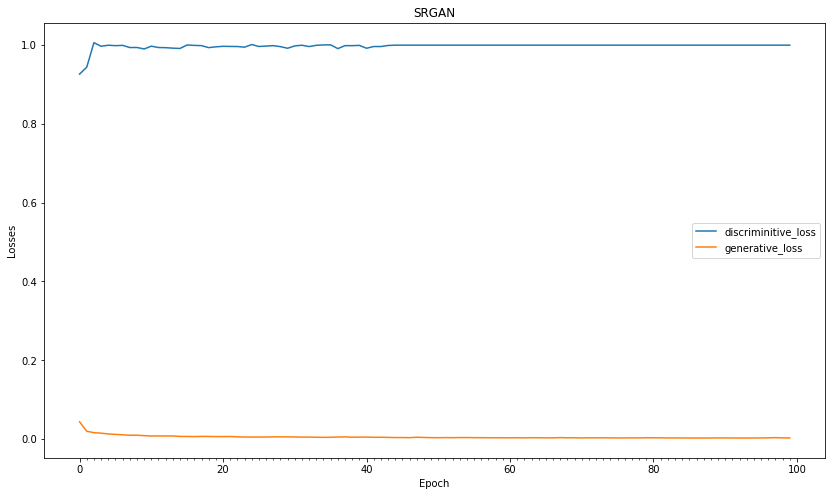

In [29]:
plot_losses(MODEL_NAME, results, f'{PLOT_DIR}/losses_plot.jpg' )

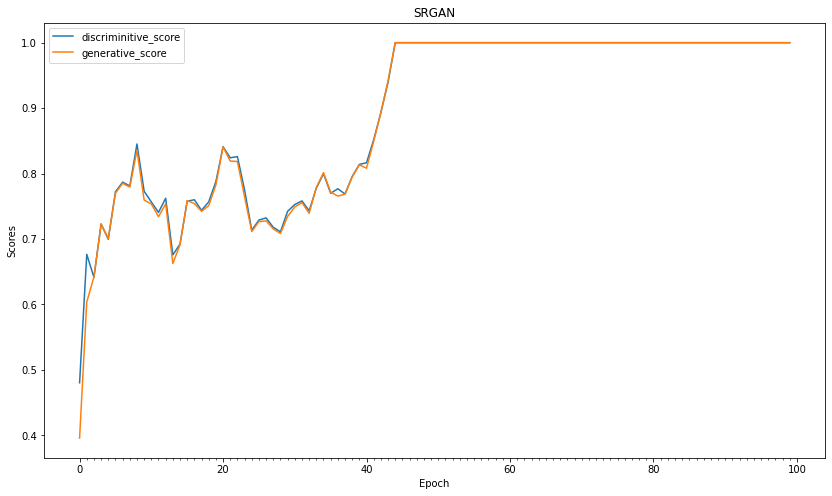

In [30]:
plot_scores(MODEL_NAME, results, f'{PLOT_DIR}/scores_plot.jpg' )

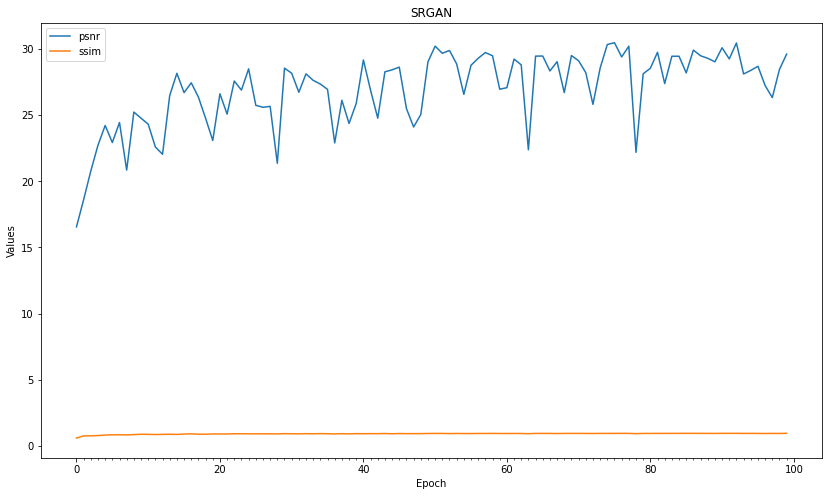

In [31]:
plot_psnr_ssim(MODEL_NAME, results, f'{PLOT_DIR}/psnr_ssim_plot.jpg' )


In [32]:
g_model = torch.load(f'{SAVED_MODELS_DIR}/srgan_netG_cuda.pt')
#decoder_model = torch.load(f'{SAVED_MODELS_DIR}/decoder_epoch1050_0.001148563549275647_cuda.pt')

In [33]:
g_model = g_model.to(device)
g_model.eval()

Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): ResidualBlock(
    (conv1)

In [34]:
from torchvision.transforms import CenterCrop, ToTensor, Resize

def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

def get_sample_images(real_image, upscale_factor):
    w, h = real_image.size
    crop_size = calculate_valid_crop_size(min(w, h), upscale_factor)
    lr_scale = Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC)
    hr_scale = Resize(crop_size, interpolation=Image.BICUBIC)
    hr_image = CenterCrop(crop_size)(real_image)
    lr_image = lr_scale(hr_image)
    hr_restore_img = hr_scale(lr_image)
    return ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

In [35]:
test_img_path = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/session8-SR/notebooks/test_images'
test_img = f'{test_img_path}/test2.jpg'
real_image = Image.open(test_img).convert('RGB')
lr, hr_restore, hr = get_sample_images(real_image, UPSCALE_FACTOR)

In [36]:
lr = lr.unsqueeze(0).to(device)
sr = g_model(lr)
sr, lr = sr.squeeze(0), lr.squeeze(0)

In [37]:
def show_result_ext(hr, hr_restore, sr):
    imgs = torch.cat([hr_restore.cpu(), hr.cpu(), sr.cpu()], dim=2)
    imgs = np.transpose(imgs.cpu().detach().numpy(),[1,2,0])
    fig = plt.figure(figsize=(10, 3))
    plt.imshow(imgs)

def show_result(hr, hr_restore, sr, save_filename=None):
    fig = plt.figure(figsize=(10,3))

    cnt=1
    ax = fig.add_subplot(1,3, cnt, xticks=[], yticks=[])
    ax.axis('off')
    ax.set_title("HR Restored")
    plt.imshow(np.transpose(hr_restore.cpu().detach().numpy(),[1,2,0]))
    
    cnt += 1
    ax = fig.add_subplot(1,3, cnt, xticks=[], yticks=[])
    ax.axis('off')
    ax.set_title('HR')
    plt.imshow(np.transpose(hr.cpu().detach().numpy(),[1,2,0]))

    cnt += 1
    ax = fig.add_subplot(1,3, cnt, xticks=[], yticks=[])
    ax.axis('off')
    ax.set_title('Super Resolution')
    plt.imshow(np.transpose(sr.cpu().detach().numpy(),[1,2,0]))

    if save_filename:
      fig.savefig(save_filename)

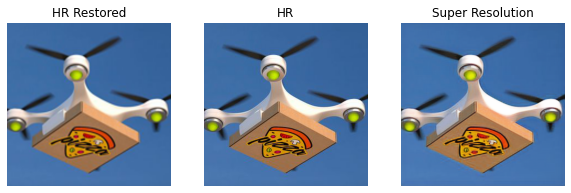

In [38]:
show_result(hr, hr_restore, sr, f'{PLOT_DIR}/result.jpg')